In [3]:
#import packages for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
#get session & role info
import sagemaker
from sagemaker import utils
from sagemaker.serializers import CSVSerializer
import boto3
import os

from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

prefix = 'CapstoneProject'
output_path = f"s3://{bucket}/{prefix}/output/"
region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-513238734400
AWS Region: us-east-1
RoleArn: arn:aws:iam::513238734400:role/service-role/AmazonSageMaker-ExecutionRole-20220121T133455


In [5]:
#AutoGluon Training
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)

In [13]:
#read in csv
data = pd.read_csv('s3://sagemaker-studio-rqk547knaq/CapstoneProject/nhes_16_pfi_pu.csv')
data.shape

(14075, 822)

In [14]:
#drop columns with weights, imputation flags, info on how survey was completed, and age/sex/grade of non-sampled children in the household
data.drop(data.loc[:, 'MODECOMP':], inplace=True, axis=1)

In [15]:
data.shape
data['SEABSNT'].max()

364

In [17]:
#drop rows with no entry for days absent from school
data = data[data['SEABSNT']!=-1]
data.shape

(13523, 372)

In [19]:
#drop children who are homeschooled, and columns related to homeschooling choices
data=data[data['HSWHOX']==-1]
data.drop(data.loc[:, 'HSWHOX':'HSNATL'], inplace=True, axis=1)

In [24]:
#drop ID number
data.drop(['BASMID', 'QTYPE'], inplace=True, axis=1)
data.describe()

,GRADE,SCPUBPRI,DISTASSI,SCHRTSCHL,SNEIGHBRX,SPUBCHOIX,SCONSIDR,SPERFORM,S1STCHOI,SSAMSC,...,ZIP18PO2,ZIPBLHI2,ZIPLOCL,S16CHART,S16NUMST,S16PBPV,S16TYPE,SCHLGRAD,ENGLSPANX,AGE2015
count,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,...,13523.000000,13523.000000,13523.00000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000,13523.000000
mean,9.658730,3.752570,0.921763,1.597796,1.815869,1.942542,1.694225,-0.325889,1.180581,1.028248,...,2.036604,2.658877,22.68964,1.625305,2.786512,1.113510,3.709606,3.036161,1.049841,12.051690
std,3.838806,0.744754,0.771633,0.959289,0.387605,0.772644,0.460752,1.039979,0.384685,0.165687,...,0.967253,1.062233,10.26508,0.975685,1.339795,0.317227,1.056901,1.249384,0.217624,3.787829
min,2.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,...,1.000000,1.000000,11.00000,-9.000000,-9.000000,1.000000,-9.000000,-9.000000,1.000000,3.000000
25%,7.000000,4.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,...,1.000000,2.000000,13.00000,2.000000,2.000000,1.000000,4.000000,2.000000,1.000000,9.000000
50%,10.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,-1.000000,1.000000,1.000000,...,2.000000,3.000000,21.00000,2.000000,3.000000,1.000000,4.000000,3.000000,1.000000,12.000000
75%,13.000000,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,3.000000,4.000000,23.00000,2.000000,4.000000,1.000000,4.000000,4.000000,1.000000,15.000000
max,15.000000,4.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,4.000000,43.00000,3.000000,5.000000,2.000000,4.000000,5.000000,2.000000,20.000000


In [36]:
#Still way too many features! We'll keep the following: current grade, type of school, 
#whether the student has been in the same school the whole year, grades, enrolled in AP classes,
#grades repeated, suspensions, expulsions, month & year of birth, country of birth, race/ethnicity, sex, enrolled in ESL, DISABILITY, zip code poverty/minority percentage/community type, school enrollment, age as of Dec 31, 2018 
#target variable is true if total absences are greater than or equal to 15 over the school year
X = data.loc[:, ['GRADE','SCPUBPRI', 'DISTASSI', 'SCHRTSCHL', 'SSAMSC', 'SEGRADES', 'SEADPLCXX', 'SEREPEAT', 'SESUSOUT', 'SESUSPIN', 'SEEXPEL', 'CDOBMM', 'CDOBYY', 'CPLCBRTH', 'CMOVEAGE', 'CHISPAN', 'CAMIND', 'CASIAN', 'CBLACK', 'CPACI', 'CWHITE','CHISPRM', 'CSEX', 'CENGLPRG','DISABLTYX', 'DISBLTY2X', 'RACEETHN', 'RACEETH2', 'ZIP18PO2', 'ZIPBLHI2','ZIPLOCL','S16NUMST', 'S16PBPV', 'S16TYPE', 'AGE2015'  ]]
y = data['SEABSNT']>=15

In [47]:
#Split into training and testing, stratified by target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [22]:
train_dataset = X_train
train_dataset['target']=y_train
test_dataset = X_test
test_dataset['target'] = y_test
train_dataset.to_csv('train.csv')
test_dataset.to_csv('test.csv')

NameError: name 'X_train' is not defined

In [60]:
#Set up AutoGluon Training container
ag = AutoGluonTraining(
    role=role,
    entry_point="tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)

In [61]:
#Upload data to S3
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path="train.csv", key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path="test.csv", key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path="config.yaml", key_prefix=s3_prefix
)

In [62]:
job_name = utils.unique_name_from_base("test-autogluon-image")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

2022-01-24 21:53:58 Starting - Starting the training job...
2022-01-24 21:54:22 Starting - Launching requested ML instancesProfilerReport-1643061238: InProgress
......
2022-01-24 21:55:22 Starting - Preparing the instances for training......
2022-01-24 21:56:22 Downloading - Downloading input data...
2022-01-24 21:56:42 Training - Downloading the training image...
2022-01-24 21:57:23 Training - Training image download completed. Training in progress.2022-01-24 21:57:18,778 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-24 21:57:18,780 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-24 21:57:18,790 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_i

In [63]:
ag.model_data

's3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643061238-ef60/output/model.tar.gz'

In [64]:
#Set up AutoGluon Training container
ag_roc_auc = AutoGluonTraining(
    role=role,
    entry_point="tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)

In [65]:
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path="train.csv", key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path="test.csv", key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path="config-roc-auc.yaml", key_prefix=s3_prefix
)

In [66]:
job_name = utils.unique_name_from_base("test-autogluon-image")
ag_roc_auc.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

2022-01-24 22:13:18 Starting - Starting the training job...
2022-01-24 22:13:45 Starting - Launching requested ML instancesProfilerReport-1643062398: InProgress
......
2022-01-24 22:14:45 Starting - Preparing the instances for training.........
2022-01-24 22:16:15 Downloading - Downloading input data...
2022-01-24 22:16:45 Training - Downloading the training image..2022-01-24 22:16:58,431 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-24 22:16:58,433 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-24 22:16:58,443 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"config":{"RecordWrapperType":"None

In [69]:
!aws s3 cp {ag_roc_auc.model_data} .

download: s3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643062398-9097/output/model.tar.gz to ./model.tar.gz


In [70]:
!ls -alF model.tar.gz

-rw-r--r-- 1 root root 28494865 Jan 24 22:19 model.tar.gz


In [15]:
!aws s3 cp {'s3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643062398-9097/output/output.tar.gz'} .

download: s3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643062398-9097/output/output.tar.gz to ./output.tar.gz


In [16]:
import tarfile
  
# open file
file = tarfile.open('output.tar.gz')
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('./output_roc_auc')
  
# close file
file.close()

['predictions.csv', 'feature_importance.csv', 'leaderboard.csv']


In [21]:
!aws s3 cp {'s3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643061238-ef60/output/output.tar.gz'} ./output_f1.tar.gz

download: s3://sagemaker-us-east-1-513238734400/test-autogluon-image-1643061238-ef60/output/output.tar.gz to ./output_f1.tar.gz


In [22]:
# open file
file = tarfile.open('output_f1.tar.gz')
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('./output_f1')
  
# close file
file.close()

['predictions.csv', 'feature_importance.csv', 'leaderboard.csv']


In [6]:
feat_importances = pd.read_csv('./output/feature_importance.csv')

In [7]:
feat_importances.rename(columns={'Unnamed: 0':'feature'}, inplace=True)

<AxesSubplot:xlabel='feature'>

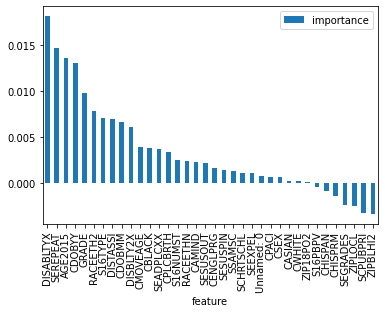

In [8]:
feat_importances.plot(x='feature', y='importance', kind='bar')
#plt.savefig('feature_importances.png')

In [9]:
feat_list = feat_importances.iloc[:5, 0].tolist()
print(feat_list)

['DISABLTYX', 'SEREPEAT', 'AGE2015', 'CDOBYY', 'GRADE']


In [10]:
feat_list.remove('CDOBYY')

In [11]:
train_dataset = pd.read_csv('train.csv', index_col=0)
X_train = train_dataset[feat_list]
y_train = train_dataset['target']
test_dataset = pd.read_csv('test.csv', index_col=0)
X_test =  test_dataset[feat_list]
y_test = test_dataset['target']

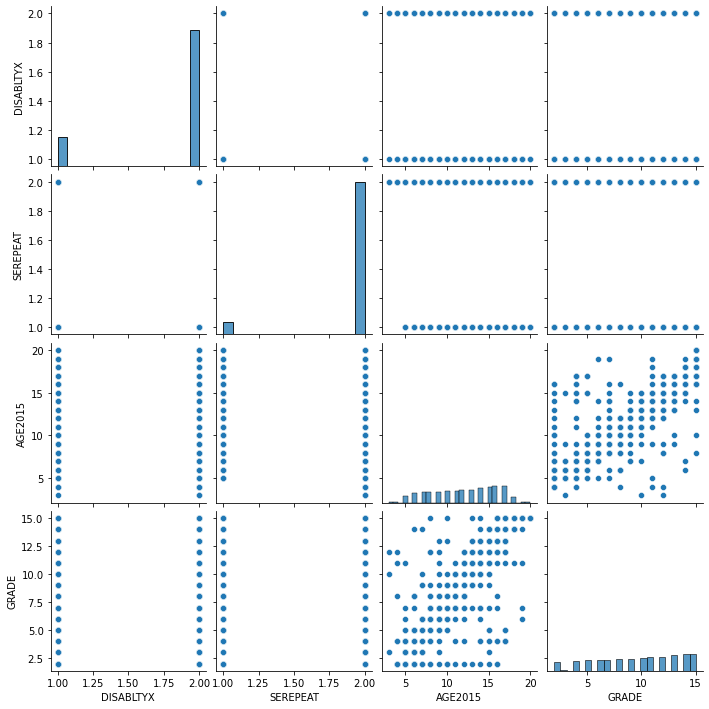

In [109]:
sns.pairplot(X_train)
#plt.savefig('red_feat_pairplot.png')

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=3)
cross_val_score(clf, X_train, y_train, cv=10)

array([0.96799117, 0.96799117, 0.96799117, 0.96799117, 0.96799117,
       0.96799117, 0.96799117, 0.96799117, 0.96799117, 0.96688742])

In [103]:
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3)

In [104]:
from sklearn.metrics import roc_auc_score, f1_score
y_pred = clf.predict(X_test)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(f"F-score: {f1_score(y_test, y_pred)}")

ROC AUC Score: 0.5
F-score: 0.0


[Text(167.4, 190.26, 'X[0] <= 1.5\ngini = 0.062\nsamples = 9060\nvalue = [8769, 291]'),
 Text(83.7, 135.9, 'X[2] <= 14.5\ngini = 0.13\nsamples = 1587\nvalue = [1476, 111]'),
 Text(41.85, 81.53999999999999, 'X[3] <= 8.5\ngini = 0.095\nsamples = 1019\nvalue = [968, 51]'),
 Text(20.925, 27.180000000000007, 'gini = 0.073\nsamples = 582\nvalue = [560, 22]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.124\nsamples = 437\nvalue = [408, 29]'),
 Text(125.55000000000001, 81.53999999999999, 'X[6] <= 1.5\ngini = 0.189\nsamples = 568\nvalue = [508, 60]'),
 Text(104.625, 27.180000000000007, 'gini = 0.172\nsamples = 484\nvalue = [438, 46]'),
 Text(146.475, 27.180000000000007, 'gini = 0.278\nsamples = 84\nvalue = [70, 14]'),
 Text(251.10000000000002, 135.9, 'X[3] <= 14.5\ngini = 0.047\nsamples = 7473\nvalue = [7293, 180]'),
 Text(209.25, 81.53999999999999, 'X[1] <= 1.5\ngini = 0.041\nsamples = 6717\nvalue = [6576, 141]'),
 Text(188.32500000000002, 27.180000000000007, 'gini = 0.096\nsample

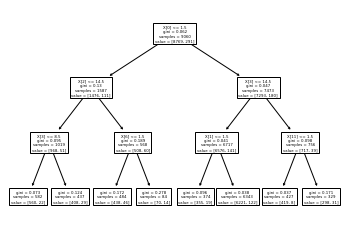

In [105]:
from sklearn import tree
tree.plot_tree(clf)

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
fclf=RandomForestClassifier(max_depth=2, max_features=2, n_estimators=100)
cross_val_score(fclf, X_train, y_train, cv=10)

array([0.96799117, 0.96799117, 0.96799117, 0.96799117, 0.96799117,
       0.96799117, 0.96799117, 0.96799117, 0.96799117, 0.96688742])

In [94]:
fclf.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, f1_score
y_pred = fclf.predict(X_test)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(f"F-score: {f1_score(y_test, y_pred)}")

ROC AUC Score: 0.5
F-score: 0.0


In [14]:
train=train_dataset[feat_list]
train['target']=train_dataset['target']
test=test_dataset[feat_list]
test['target']=test_dataset['target']
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9060 entries, 0 to 9059
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   DISABLTYX  9060 non-null   int64
 1   SEREPEAT   9060 non-null   int64
 2   AGE2015    9060 non-null   int64
 3   GRADE      9060 non-null   int64
 4   target     9060 non-null   bool 
dtypes: bool(1), int64(4)
memory usage: 362.8 KB


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,DISABLTYX,SEREPEAT,AGE2015,GRADE
count,9060.000000,9060.000000,9060.000000,9060.000000
mean,1.824834,1.923620,12.047020,9.655298
std,0.380130,0.265619,3.790664,3.844656
min,1.000000,1.000000,3.000000,2.000000
25%,2.000000,2.000000,9.000000,7.000000
50%,2.000000,2.000000,12.000000,10.000000
75%,2.000000,2.000000,15.000000,13.000000
max,2.000000,2.000000,20.000000,15.000000


In [139]:
import autogluon.core as ag
num_trials = 5
search_strategy = 'auto'
rf_options = {
    'max_depth': 2
}
cat_options = {
   'learning_rate':ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  
}
nn_options = {
    'num_epochs' :10,
    'learning_rate':ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)
}
hyperparameters = {
    'RF':rf_options,
#    'CAT':cat_options,
#    'NN':nn_options,
}
hyperparameter_tune_kwargs = {
    'num_trials':num_trials,
    'scheduler':'local',
    'searcher':search_strategy,
}

In [ ]:
predictor_fewer_features = TabularPredictor(
    label='target',
    problem_type='binary',
    eval_metric='roc_auc'
).fit(
    train_data=train, 
    time_limit=1000, 
    presets='best_quality', 
#    hyperparameters=hyperparameters,
#    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220125_052057/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20220125_052057/"
AutoGluon Version:  0.3.1
Train Data Rows:    9060
Train Data Columns: 4
Preprocessing data ...
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12042.89 MB
	Train Data (Original)  Memory Usage: 0.16 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatu

In [30]:
#Set up AutoGluon Training container
ag_small = AutoGluonTraining(
    role=role,
    entry_point="tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train-small",
)

In [24]:
train.to_csv('train_small.csv', index=False)
test.to_csv('test_small.csv', index=False)

In [31]:
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag_small.sagemaker_session.upload_data(
    path="train_small.csv", key_prefix=s3_prefix
)
eval_input = ag_small.sagemaker_session.upload_data(
    path="test_small.csv", key_prefix=s3_prefix
)
config_input = ag_small.sagemaker_session.upload_data(
    path="config-roc-auc.yaml", key_prefix=s3_prefix
)

In [32]:
job_name = utils.unique_name_from_base("autogluon-small")
ag_small.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

2022-01-25 06:11:53 Starting - Starting the training job...
2022-01-25 06:12:17 Starting - Launching requested ML instancesProfilerReport-1643091113: InProgress
......
2022-01-25 06:13:17 Starting - Preparing the instances for training............
2022-01-25 06:15:18 Downloading - Downloading input data
2022-01-25 06:15:18 Training - Downloading the training image...
2022-01-25 06:15:54 Training - Training image download completed. Training in progress..2022-01-25 06:15:55,000 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-25 06:15:55,002 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-25 06:15:55,013 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'tabular_train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"netwo

In [33]:
ag_small.model_data

's3://sagemaker-us-east-1-513238734400/autogluon-small-1643091113-1254/output/model.tar.gz'

In [34]:
!aws s3 cp {'s3://sagemaker-us-east-1-513238734400/autogluon-small-1643091113-1254/output/output.tar.gz'} ./output_small.tar.gz

download: s3://sagemaker-us-east-1-513238734400/autogluon-small-1643091113-1254/output/output.tar.gz to ./output_small.tar.gz


In [35]:
# open file
file = tarfile.open('output_small.tar.gz')
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('./output_small')
  
# close file
file.close()

['leaderboard.csv', 'predictions.csv', 'feature_importance.csv']
